In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py

import scipy.stats as ss
from sklearn.metrics import r2_score, average_precision_score, roc_auc_score

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

## Yeast S288C data

In [2]:
## Yeast gene name mapping
yeast_name_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

### Fig. 1C: Model accuracy on yeast TFs using all binding location data

In [3]:
feat_types = ['all_feats']

stats_arr = []

## Calling cards vs ZEV using RF classifier
algo = 'rf'
dirpath = '../OUTPUT/Yeast_cc_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'Calling cards'
stats_arr.append(stats)

## Calling cards vs ZEV using XGBoost classifier
algo = 'xgb'
dirpath = '../OUTPUT/Yeast_cc_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'Calling cards'
stats_arr.append(stats)

## ChIPexo vs ZEV using RF classifier
algo = 'rf'
dirpath = '../OUTPUT/Yeast_chipexo_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'ChIP-exo'
stats_arr.append(stats)

## ChIPexo vs ZEV using XGBoost classifier
algo = 'xgb'
dirpath = '../OUTPUT/Yeast_chipexo_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['algorithm'] = algo
stats['tfb'] = 'ChIP-exo'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)

... working on all_feats
... working on all_feats
... working on all_feats
... working on all_feats


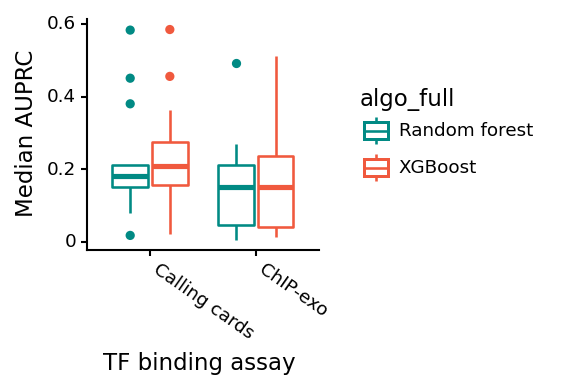

<ggplot: (-9223372029842877019)>

In [4]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['tf', 'tfb', 'algorithm'])[['auprc']].median().reset_index()
med_df.loc[med_df['algorithm'] == 'rf', 'algo_full'] = 'Random forest'
med_df.loc[med_df['algorithm'] == 'xgb', 'algo_full'] = 'XGBoost'

## Plot boxplots
ax = (
    ggplot(med_df, aes(x='tfb', y='auprc', color='algo_full'))
    + geom_boxplot(size=.7)
    + scale_color_manual(values=[COLORS['dark_green'], COLORS['orange']])
    + xlab('TF binding assay')
    + ylab('Median AUPRC')
    + theme_classic()
    + theme(figure_size=(2, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 1D: Model accuracy on eight yeast TFs with binding location data from both ChIP-exo and calling cards assays

In [5]:
feat_types = ['all_feats']
algo = 'xgb' ## All using XGBoost classifier

stats_arr = []

## Calling cards vs ZEV
dirpath = '../OUTPUT/Yeast_cc_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats_arr.append(stats)

## ChIPexo vs ZEV
dirpath = '../OUTPUT/Yeast_chipexo_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats_arr.append(stats)

## Binding potentials vs ZEV
dirpath = '../OUTPUT/Yeast_bp_zev'
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Binding potentials'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
stats_df['tfb'] = pd.Categorical(
    stats_df['tfb'], ordered=True,
    categories=['Binding potentials', 'ChIP-exo', 'Calling cards'])

... working on all_feats
... working on all_feats
... working on all_feats


In [6]:
## Get common yeast TFs 
common_yeast_tfs = np.intersect1d(
    np.loadtxt('../RESOURCES/Yeast_CallingCards_TFs.txt', dtype=str),
    np.loadtxt('../RESOURCES/Yeast_ChIPexo_TFs.txt', dtype=str))
common_yeast_tfs = ['{} ({})'.format(x, yeast_name_dict[x]) for x in common_yeast_tfs]

print('Common yeast TFs (n={}): {}'.format(len(common_yeast_tfs), common_yeast_tfs))

Common yeast TFs (n=8): ['YEL009C (GCN4)', 'YJR060W (CBF1)', 'YKL038W (RGT1)', 'YLR451W (LEU3)', 'YNL199C (GCR2)', 'YOL108C (INO4)', 'YOR344C (TYE7)', 'YPL075W (GCR1)']


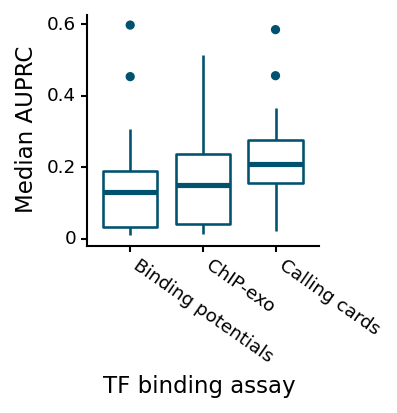

<ggplot: (7012618374)>

In [7]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['tf', 'tfb'])[['auprc']].median().reset_index()

## Plot boxplots
ax = (
    ggplot(med_df, aes(x='tfb', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7)
    + xlab('TF binding assay')
    + ylab('Median AUPRC')
    + theme_classic()
    + theme(
        figure_size=(2, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 2D: Comparison of yeast model accuracy using four types of input features
1. Full model
2. The model trained without TF binding features
3. The model without gene expression features
4. The model without histone marks (HMs)

In [8]:
algo = 'xgb'

stats_arr = []

## Calling cards: Full model
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Full model'
stats_arr.append(stats)

## Calling cards: Excl. TF binding
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['dna_hm_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Excl. TF binding'
stats_arr.append(stats)

## Calling cards: Excl. GEX
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['tfb_hm_atac_dna']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Excl. GEX'
stats_arr.append(stats)

## Calling cards: Excl. HMs
dirpath = '../OUTPUT/Yeast_cc_zev'
feat_types = ['dna_tfb_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'Calling cards'
stats['model_type'] = 'Excl. HMs'
stats_arr.append(stats)

## --------------------
## ChIP-exo: Full model
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Full model'
stats_arr.append(stats)

## ChIP-exo: Excl. TF binding
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['dna_hm_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Excl. TF binding'
stats_arr.append(stats)

## ChIP-exo: Excl. GEX
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['tfb_hm_atac_dna']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Excl. GEX'
stats_arr.append(stats)

## ChIP-exo: Excl. HMs
dirpath = '../OUTPUT/Yeast_chipexo_zev'
feat_types = ['dna_tfb_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, yeast_name_dict)
stats['tfb'] = 'ChIP-exo'
stats['model_type'] = 'Excl. HMs'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
model_types = ['Full model', 'Excl. TF binding', 'Excl. GEX', 'Excl. HMs']
stats_df['model_type'] = pd.Categorical(
    stats_df['model_type'], ordered=True, 
    categories=model_types)

... working on all_feats
... working on dna_hm_atac_expr
... working on tfb_hm_atac_dna
... working on dna_tfb_atac_expr
... working on all_feats
... working on dna_hm_atac_expr
... working on tfb_hm_atac_dna
... working on dna_tfb_atac_expr


,Model x,Model y,Median AUC x,Median AUC y,Median diff (x-y),Avg AUC x,Avg AUC y,Avg diff (x-y),Pval (paired t-test)
0,Full model,Excl. TF binding,0.161352,0.121230,0.040122,0.19327,0.141142,0.052128,0.000502
1,Full model,Excl. GEX,0.161352,0.159735,0.001617,0.19327,0.174684,0.018585,0.000209
2,Full model,Excl. HMs,0.161352,0.167794,-0.006442,0.19327,0.183489,0.009781,0.039365


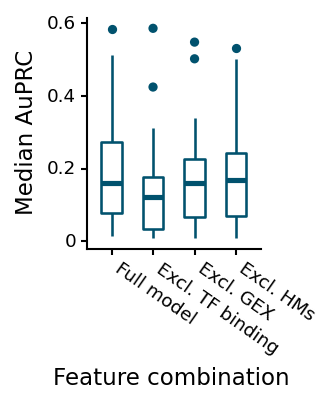

<ggplot: (7012659120)>

In [9]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['tf', 'tfb', 'model_type'])[['auprc']].median().reset_index()

## Get the best TFB type for each TF
tfb_valid = []
for tf, subdf in med_df[med_df['model_type'] == 'Full model'].groupby('tf'):
    row = subdf.iloc[subdf['auprc'].argmax()]
    tfb_valid.append(row['tf'] + ':' + row['tfb'])

med_df['tf:tfb'] = med_df['tf'] + ':' + med_df['tfb']
med_df2 = med_df[med_df['tf:tfb'].isin(tfb_valid)]

## Add statistics
sum_stats = pd.DataFrame()
for i, model_type in enumerate(model_types[1:]):
    x_aucs = med_df2.loc[med_df2['model_type'] == model_types[0], 'auprc']
    y_aucs = med_df2.loc[med_df2['model_type'] == model_types[i + 1], 'auprc']
    _, p = ss.ttest_rel(x_aucs, y_aucs)
    sum_stats = sum_stats.append(pd.Series({
        'Model x': model_types[0],
        'Model y': model_types[i + 1],
        'Median AUC x': np.median(x_aucs),
        'Median AUC y': np.median(y_aucs),
        'Median diff (x-y)': np.median(x_aucs) - np.median(y_aucs),
        'Avg AUC x': np.mean(x_aucs),
        'Avg AUC y': np.mean(y_aucs),
        'Avg diff (x-y)': np.mean(x_aucs) - np.mean(y_aucs),
        'Pval (paired t-test)': p
    }), ignore_index=True)

display(sum_stats[['Model x', 'Model y', 'Median AUC x', 'Median AUC y', 'Median diff (x-y)', 
                   'Avg AUC x', 'Avg AUC y', 'Avg diff (x-y)', 'Pval (paired t-test)']])

## Plot boxplots
ax = (
    ggplot(med_df2, aes(x='model_type', y='auprc'))
    + geom_boxplot(size=.7, width=.5, color=COLORS['dark_blue'])
    + labs(x='Feature combination', y='Median AuPRC')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

---
## Human K562 data

In [10]:
## Human gene name mapping
human_name_dict = {
    row['#ensembl_gene_id']: row['external_gene_name'] \
    for _, row in pd.read_csv(
        '../RESOURCES/Human_genome/genes.protein_coding.BioMart.tbl', 
        sep='\t', usecols=[0, 1]
    ).iterrows()}

### Fig. 1E: Model accuracy on human K562 cells using two methods of aggregating data from enhancers associated with each gene

In [11]:
algo = 'xgb'
feat_types = ['all_feats']

stats_arr = []

## Promoters + binned enhancers
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbBinned_5primPromo2kb'
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['reg_dna'] = 'prom + bin enhan'
stats_arr.append(stats)

## Promoters + aggregated enhancers
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['reg_dna'] = 'prom + agg enhan'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
stats_df['reg_dna'] = pd.Categorical(
    stats_df['reg_dna'], ordered=True, 
    categories=['prom + bin enhan', 'prom + agg enhan'])

... working on all_feats
... working on all_feats


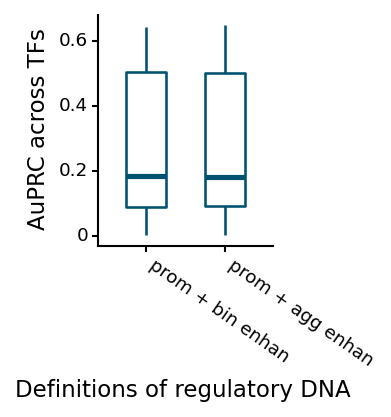

<ggplot: (7012910179)>

In [12]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['feat_type', 'reg_dna', 'tf_com'])[['auprc', 'chance']].median().reset_index()

ax = (
    ggplot(
        med_df, 
        aes(x='reg_dna', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
    + xlab('Definitions of regulatory DNA')
    + ylab('AuPRC across TFs')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(angle=-35, hjust=0, color='#000000'),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 2F: Comparison of human model accuracy using five types of input features
1. Full model
2. The model trained without TF binding features
3. The model without gene expression features
4. The model without histone marks (HMs)
5. GEX only features

In [13]:
algo = 'xgb'

stats_arr = []

## Full model
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Full model'
stats_arr.append(stats)

## Excl. TF binding
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['dna_hm_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Excl. TF binding'
stats_arr.append(stats)

## Excl. GEX
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['tfb_hm_atac_dna']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Excl. GEX'
stats_arr.append(stats)

## Excl. HMs
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['dna_tfb_atac_expr']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Excl. HMs'
stats_arr.append(stats)

## GEX only
dirpath = '../OUTPUT/Human_chip_pert_5primGenebody2kb'
feat_types = ['gex']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'GEX only'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
model_types = ['Full model', 'Excl. TF binding', 'Excl. GEX', 'Excl. HMs', 'GEX only']
stats_df['model_type'] = pd.Categorical(
    stats_df['model_type'], ordered=True, 
    categories=model_types)

... working on all_feats
... working on dna_hm_atac_expr
... working on tfb_hm_atac_dna
... working on dna_tfb_atac_expr
... working on gex


,Model x,Model y,Median AUC x,Median AUC y,Median diff (x-y),Avg AUC x,Avg AUC y,Avg diff (x-y),Pval (paired t-test)
0,Full model,Excl. TF binding,0.179717,0.180120,-0.000403,0.257825,0.257946,-0.000121,7.808341e-01
1,Full model,Excl. GEX,0.179717,0.110265,0.069453,0.257825,0.184262,0.073563,7.909238e-16
2,Full model,Excl. HMs,0.179717,0.183762,-0.004045,0.257825,0.255505,0.002321,1.012888e-01
3,Full model,GEX only,0.179717,0.159750,0.019967,0.257825,0.223283,0.034542,4.413676e-10
4,Excl. TF binding,Excl. GEX,0.180120,0.110265,0.069856,0.257946,0.184262,0.073684,8.673160e-16
5,Excl. TF binding,Excl. HMs,0.180120,0.183762,-0.003642,0.257946,0.255505,0.002441,7.021966e-02
6,Excl. TF binding,GEX only,0.180120,0.159750,0.020370,0.257946,0.223283,0.034662,2.934477e-10
7,Excl. GEX,Excl. HMs,0.110265,0.183762,-0.073498,0.184262,0.255505,-0.071243,1.902819e-16
8,Excl. GEX,GEX only,0.110265,0.159750,-0.049486,0.184262,0.223283,-0.039022,9.437065e-10
9,Excl. HMs,GEX only,0.183762,0.159750,0.024012,0.255505,0.223283,0.032221,2.576674e-10


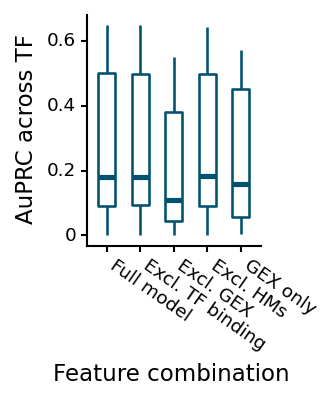

<ggplot: (7012214676)>

In [14]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['model_type', 'tf_com'])[['auprc', 'chance']].median().reset_index()

## Filter for the common TFs (2 of all K562 TFs don't have binding data)
human_tfs = np.loadtxt('../RESOURCES/Human_ENCODE_K562_TFs.txt', dtype=str)
tf_cnts = med_df.groupby('tf_com')['tf_com'].count()
human_tfs = tf_cnts[tf_cnts == len(model_types)].index.values
med_df = med_df[med_df['tf_com'].isin(human_tfs)]

## Calculate pairwise statistics
sum_stats = pd.DataFrame()
for i, x in enumerate(model_types):
    for j, y in enumerate(model_types):
        if j <= i:
            continue
        x_aucs = med_df[med_df['model_type'] == x].set_index('tf_com').loc[human_tfs]['auprc']
        y_aucs = med_df[med_df['model_type'] == y].set_index('tf_com').loc[human_tfs]['auprc']
        x_aucs = x_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        y_aucs = y_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        _, p = ss.ttest_rel(x_aucs, y_aucs)
        
        sum_stats = sum_stats.append(pd.Series({
            'Model x': x,
            'Model y': y,
            'Median AUC x': np.median(x_aucs),
            'Median AUC y': np.median(y_aucs),
            'Median diff (x-y)': np.median(x_aucs) - np.median(y_aucs),
            'Avg AUC x': np.mean(x_aucs),
            'Avg AUC y': np.mean(y_aucs),
            'Avg diff (x-y)': np.mean(x_aucs) - np.mean(y_aucs),
            'Pval (paired t-test)': p
        }), ignore_index=True)

display(sum_stats[['Model x', 'Model y', 'Median AUC x', 'Median AUC y', 'Median diff (x-y)', 
                   'Avg AUC x', 'Avg AUC y', 'Avg diff (x-y)', 'Pval (paired t-test)']])
        
ax = (
    ggplot(med_df, aes(x='model_type', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
    + xlab('Feature combination')
    + ylab('AuPRC across TF')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(color='#000000', angle=-35, hjust=0),
           axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 2H: Comparison of human model accuracy using four types of input features
1. Full model
2. The model excluding enhancer features (Promo only)
3. The model excluding enhancer features and features mapped upstream of the TSS (Gene body 2Kb)
4. The model using only pre-perturbation gene expression features (GEX only)

In [15]:
algo = 'xgb'

stats_arr = []

## Enhan + promo
dirpath = '../OUTPUT/Human_chip_pert_enhanPromo500kbSingle_5primPromo2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Enhan + promo'
stats_arr.append(stats)

## Promo only
dirpath = '../OUTPUT/Human_chip_pert_5primPromo2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Promo only'
stats_arr.append(stats)

## Gene body 2kb
dirpath = '../OUTPUT/Human_chip_pert_5primGenebody2kb'
feat_types = ['all_feats']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'Gene body 2kb'
stats_arr.append(stats)

## GEX only
dirpath = '../OUTPUT/Human_chip_pert_5primGenebody2kb'
feat_types = ['gex']
stats = parse_classifier_stats(dirpath, algo, feat_types, human_name_dict)
stats['model_type'] = 'GEX only'
stats_arr.append(stats)

stats_df = pd.concat(stats_arr)
model_types = ['Enhan + promo', 'Promo only', 'Gene body 2kb', 'GEX only']
stats_df['model_type'] = pd.Categorical(
    stats_df['model_type'], ordered=True, 
    categories=model_types)

... working on all_feats
... working on all_feats
... working on all_feats
... working on gex


,Model x,Model y,Median AUC x,Median AUC y,Median diff (x-y),Avg AUC x,Avg AUC y,Avg diff (x-y),Pval (paired t-test)
0,Enhan + promo,Promo only,0.179717,0.175965,0.003753,0.257825,0.248935,0.008891,1.395371e-04
1,Enhan + promo,Gene body 2kb,0.179717,0.181503,-0.001786,0.257825,0.250381,0.007444,1.909572e-03
2,Enhan + promo,GEX only,0.179717,0.159750,0.019967,0.257825,0.223283,0.034542,4.413676e-10
3,Promo only,Gene body 2kb,0.175965,0.181503,-0.005538,0.248935,0.250381,-0.001447,2.030124e-02
4,Promo only,GEX only,0.175965,0.159750,0.016214,0.248935,0.223283,0.025651,1.238230e-10
5,Gene body 2kb,GEX only,0.181503,0.159750,0.021753,0.250381,0.223283,0.027098,2.369869e-11


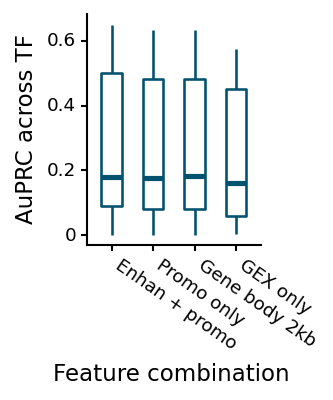

<ggplot: (-9223372029842553596)>

In [16]:
## Calculate AUC of median fold for each TF model
med_df = stats_df.groupby(['model_type', 'tf_com'])[['auprc', 'chance']].median().reset_index()

## Filter for the common TFs (2 of all K562 TFs don't have binding data)
human_tfs = np.loadtxt('../RESOURCES/Human_ENCODE_K562_TFs.txt', dtype=str)
tf_cnts = med_df.groupby('tf_com')['tf_com'].count()
human_tfs = tf_cnts[tf_cnts == len(model_types)].index.values
med_df = med_df[med_df['tf_com'].isin(human_tfs)]

## Calculate pairwise statistics
sum_stats = pd.DataFrame()
for i, x in enumerate(model_types):
    for j, y in enumerate(model_types):
        if j <= i:
            continue
        x_aucs = med_df[med_df['model_type'] == x].set_index('tf_com').loc[human_tfs]['auprc']
        y_aucs = med_df[med_df['model_type'] == y].set_index('tf_com').loc[human_tfs]['auprc']
        x_aucs = x_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        y_aucs = y_aucs[(~x_aucs.isnull()) & (~y_aucs.isnull())]
        _, p = ss.ttest_rel(x_aucs, y_aucs)
        
        sum_stats = sum_stats.append(pd.Series({
            'Model x': x,
            'Model y': y,
            'Median AUC x': np.median(x_aucs),
            'Median AUC y': np.median(y_aucs),
            'Median diff (x-y)': np.median(x_aucs) - np.median(y_aucs),
            'Avg AUC x': np.mean(x_aucs),
            'Avg AUC y': np.mean(y_aucs),
            'Avg diff (x-y)': np.mean(x_aucs) - np.mean(y_aucs),
            'Pval (paired t-test)': p
        }), ignore_index=True)

display(sum_stats[['Model x', 'Model y', 'Median AUC x', 'Median AUC y', 'Median diff (x-y)', 
                   'Avg AUC x', 'Avg AUC y', 'Avg diff (x-y)', 'Pval (paired t-test)']])
        
ax = (
    ggplot(med_df, aes(x='model_type', y='auprc'))
    + geom_boxplot(color=COLORS['dark_blue'], size=.7, width=.5)
    + xlab('Feature combination')
    + ylab('AuPRC across TF')
    + theme_classic()
    + theme(figure_size=(1.5, 2), dpi=150,
           axis_text_x=element_text(color='#000000', angle=-35, hjust=0),
           axis_text_y=element_text(color='#000000'))
)
display(ax)